In [1]:
#모듈 임포트
import pandas as pd
import urllib.request
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2

In [2]:
!mkdir /content/images

In [3]:
df = pd.read_csv('/content/image_url.csv')

# 이미지 저장

In [ ]:
#get

for i in range(len(df['url'])):
  url = df['url'][i]
  urllib.request.urlretrieve(url, '/content/images/thumbnail{0:04d}.jpg'.format(i))
  print('image {} 저장'.format(i))

In [75]:
filenames = os.listdir('/content/images')
filenames.sort()

# 이미지 로드

In [104]:
def load_image(filename):
  image = tf.io.read_file('/content/images/{}'.format(filename))
  image = tf.image.decode_jpeg(image, channels=3)
  # image = tf.image.convert_image_dtype(image, tf.float32)
  return image

In [211]:
images = load_image(filenames[0])
images = np.array(images)
images = images.reshape(1, 90, 83, 3)

for filename in filenames[1:]:
  img1 = load_image(filename)
  img1 = np.array(img1)
  img1 = img1.reshape(1, 90, 83, 3)
  # img1 = img1.reshape(1, -1, 3).astype(np.float32)
  images = np.concatenate([images, img1])

In [212]:
images.shape #3차원으로 이미지 455개 가져오기

(455, 90, 83, 3)

#OpenCV K-Means
- 주요하게 쓰이는 색깔 개수에 맞춰 골라내기

In [189]:
import cv2

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
img_set = img.reshape(455, -1, 3).astype(np.float32)

image_trans_ls = []
center_ls =[]

for k in range(3, 11):
  print('k :', k)
  #label은 각각의 데이터가 속한 군집 정보. center은 군집의 중심점 좌표.
  ret, label, center = cv2.kmeans(img_set[0], k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

  center = np.uint8(center)  #k개의 색깔

  image_trans = center[label.flatten()]

  image_trans = image_trans.reshape((img_set[0].shape))

  image_trans_ls.append(image_trans)
  center_ls.append(center)

k : 3
k : 4
k : 5
k : 6
k : 7
k : 8
k : 9
k : 10


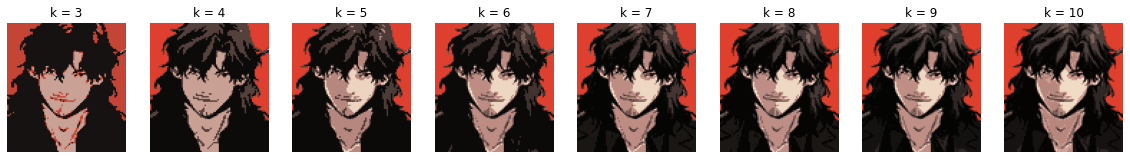

In [196]:
figure, axs = plt.subplots(figsize=(20, 50), ncols=len(image_trans_ls), nrows=1)
for i in range(len(image_trans_ls)):
  axs[i].imshow(image_trans_ls[i].reshape(90, 83, 3))
  axs[i].axis('off')
  axs[i].set_title('k = {}'.format(i+3))

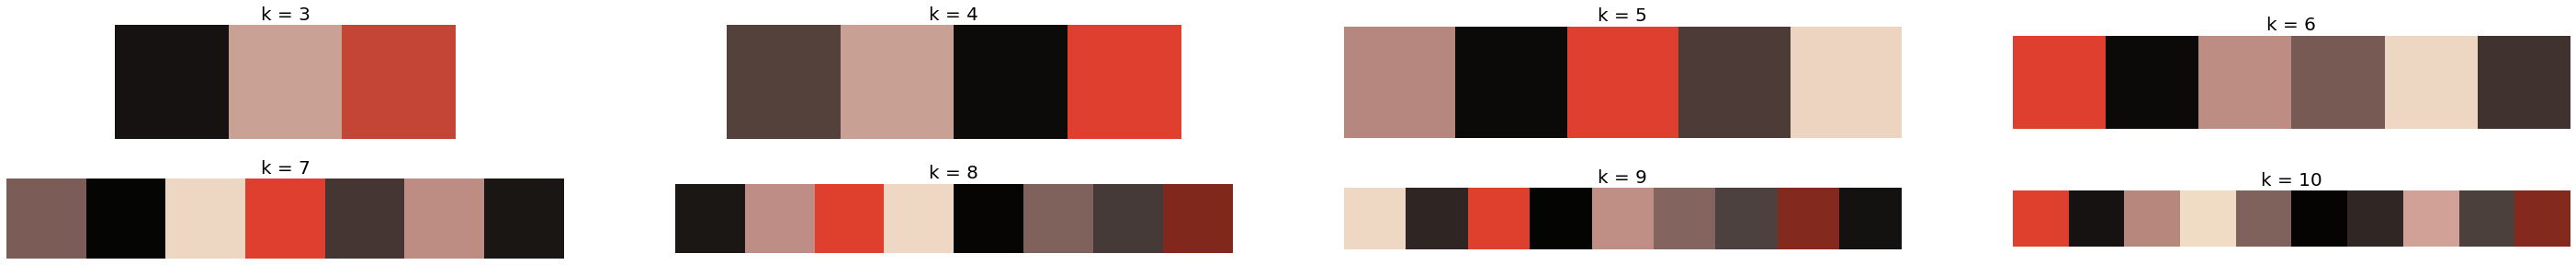

In [209]:
ncols = int(len(center_ls)/2)
figure, axs = plt.subplots(figsize=(50, 5), ncols=ncols, nrows=2)
for i in range(len(center_ls)):
  axs[i//ncols, i%ncols].imshow(center_ls[i].reshape(1, i+3, 3))
  axs[i//ncols, i%ncols].axis('off')
  axs[i//ncols, i%ncols].set_title('k = {}'.format(i+3), fontdict={'fontsize':20})

# 이미지 3색 표현

In [239]:
!mkdir /content/drive/MyDrive/image_result/image_map

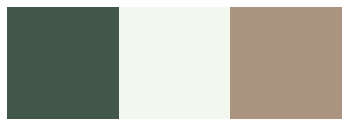

In [284]:
#이미지 455개 shape 변환

images_map_3 =[]

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
img_set = img.reshape(455, -1, 3).astype(np.float32)

for i in range(len(images)):
  ret, label, center = cv2.kmeans(img_set[i], 3, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

  center = np.uint8(center)
  center = center.reshape(1, 3, 3)
  images_map_3.append(center)

  plt.imshow(center)
  plt.axis('off')

# 3 colors image clustering
- 클러스터링 개수 : 30 good
- 3색이 4색보다 특징을 확실히 잡아줘서 더 분류가 잘 되는 느낌.

In [343]:
images_map_3 = np.array(images_map_3)
images_map_3 = images_map_3.reshape(455, 9)

In [373]:
kmeans = KMeans(n_clusters=60, n_jobs=-1, random_state=22) #clusters=30개 괜찮았음.

labels = kmeans.fit_predict(images_map_3)

<BarContainer object of 60 artists>

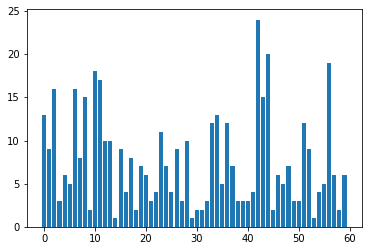

In [374]:
label_unique = pd.Series(kmeans.labels_).unique()
plt.bar(label_unique,pd.Series(kmeans.labels_).value_counts())

In [370]:
groups = {}

for filename, cluster in zip(filenames, kmeans.labels_):
  if cluster not in groups.keys():
    groups[cluster] = []
    groups[cluster].append(filename)
  else:
    groups[cluster].append(filename)

In [371]:
# !mkdir /content/drive/MyDrive/image_result/3_color
!mkdir /content/drive/MyDrive/image_result/3_color/30clusters

In [372]:
for j in range(len(groups)):
  ls = groups[j]
  if len(ls)==1:
    pass
  else:

    figure, axs = plt.subplots(figsize=(150, 20), ncols=len(ls), nrows=1)
    for i in range(len(ls)):
      axs[i].imshow(load_image(ls[i]))
      axs[i].axis('off')
    plt.savefig('/content/drive/MyDrive/image_result/3_color/30clusters/{0:03d}.jpg'.format(j))
  print('{} 완료'.format(j+1))

# 4색 이미지

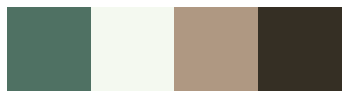

In [310]:
#이미지 455개 shape 변환

images_map_4 =[]

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
img_set = img.reshape(455, -1, 3).astype(np.float32)

for i in range(len(images)):
  ret, label, center = cv2.kmeans(img_set[i], 4, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

  center = np.uint8(center)
  center = center.reshape(1, 4, 3)
  images_map_4.append(center)

  plt.imshow(center)
  plt.axis('off')

In [313]:
images_map_4 = np.array(images_map_4)
images_map_4 = images_map_4.reshape(455, 12)

kmeans = KMeans(n_clusters=30, n_jobs=-1, random_state=22) #clusters=30개 괜찮았음.

labels = kmeans.fit_predict(images_map_4)

<BarContainer object of 30 artists>

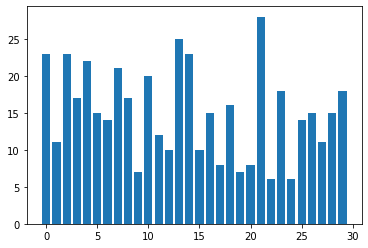

In [316]:
label_unique = pd.Series(kmeans.labels_).unique()
plt.bar(label_unique,pd.Series(kmeans.labels_).value_counts())

In [314]:
groups = {}

for filename, cluster in zip(filenames, kmeans.labels_):
  if cluster not in groups.keys():
    groups[cluster] = []
    groups[cluster].append(filename)
  else:
    groups[cluster].append(filename)

In [ ]:
!mkdir /content/drive/MyDrive/image_result/4_color

In [315]:
for j in range(len(groups)):
  ls = groups[j]
  figure, axs = plt.subplots(figsize=(150, 20), ncols=len(ls), nrows=1)
  for i in range(len(ls)):
    axs[i].imshow(load_image(ls[i]))
    axs[i].axis('off')
  plt.savefig('/content/drive/MyDrive/image_result/4_color/30clusters_{0:03d}.jpg'.format(j))

Output hidden; open in https://colab.research.google.com to view.